In [10]:
import scipy.io as sio
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np 
import math
import pandas as pd
import cmath
import scipy.io as sio
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import math
import pandas as pd
import cmath
from torch import nn
#from unet import UNet
# from auto import encoder, decoder

from collections import OrderedDict
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
#==========================================================================
# For Plotting loss graph
# Bokeh
from bokeh.io import curdoc
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

from functools import partial
from threading import Thread
from tornado import gen
# from AttRCNN_UNet import Att_R2U
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
import sys
# from dataloader import norm

import wandb
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=181):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=(5,3), stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=1)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=1)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=1)
        self.linear = nn.Linear(25, num_classes)
        #self.flat = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1)
        self.flat = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1))

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # print("Input ==> ", x.size())
        out = F.relu(self.bn1(self.conv1(x)))
        # print("F.relu(self.bn1(self.conv1(x))) ==> ", x.size())
        out = self.layer1(out)
        # print("layer1 ==> ", x.size())
        out = self.layer2(out)
        # print("layer2 ==> ", x.size())
        out = self.layer3(out)
        # print("layer3 ==> ", x.size())
        out = self.layer4(out)
        # print("layer4 ==>", out.size())
        out = F.avg_pool2d(out, (2,4))
        # print("avg_pool2d ===>", out.size())
        # out = out.view(out.size(0), -1)
        # print("out.view ===>", out.size())
        out = self.linear(out)
        out = self.flat(out)
#         print("Out ===>", out.size())
        return out

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


if __name__ == "__main__":
    image = torch.rand(1, 3, 8, 100)
    model = ResNet34()
    model(image)


In [3]:
train_dataset_list = []
test_dataset_list = []

In [5]:
import csv
from sklearn.model_selection import train_test_split

In [6]:
df1  = sio.loadmat("../datasets/DOA3/SNR_NS_0_3_100000.mat")
df2  = sio.loadmat("../datasets/DOA3/SNR_NS_10_3_100000.mat")
df3  = sio.loadmat("../datasets/DOA3/SNR_NS_20_3_100000.mat")
df4  = sio.loadmat("../datasets/DOA3/SNR_NS_30_3_100000.mat")
df5  = sio.loadmat("../datasets/DOA3/SNR_NS_40_3_100000.mat")

In [7]:
df = [df1, df2, df3, df4, df5]

In [8]:
(df1["NS_data"].shape)

(8, 100, 100000)

In [9]:
new_train_dataset_list = []
new_test_dataset_list = []
train_dataset_list_label = []
test_dataset_list_label = []

In [11]:
def create_dataset(df):
    data = np.transpose(df['NS_data'], (2, 0, 1))
    label = df['DOA']
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.15, random_state=42)
    new_train_dataset_list.extend(X_train)
    new_test_dataset_list.append(X_test.tolist())
    train_dataset_list_label.extend(y_train)
    test_dataset_list_label.append(y_test.tolist())

In [12]:
for file in df:
    create_dataset(file)

In [13]:
del df
del df1
del df2
del df3
del df4
del df5

In [14]:
len(test_dataset_list_label[0])

15000

In [15]:
for idx, data in enumerate(new_train_dataset_list):
    new = np.zeros((3, 8, 100))
    for j in range(0, data.shape[0]):
        for k in range(0, data.shape[1]):
            new[0][j][k] = data[j][k].real
            new[1][j][k] = data[j][k].imag
            new[2][j][k] = cmath.phase(data[j][k])
    new_train_dataset_list[idx] = new

In [16]:
len(new_train_dataset_list)

425000

In [17]:
for idx, data in enumerate(new_test_dataset_list):
    for i, ndata in enumerate(data):
        new = np.zeros((3, 8, 100))
        for j in range(0, 8):
            for k in range(0, 100):
                new[0][j][k] = ndata[j][k].real
                new[1][j][k] = ndata[j][k].imag
                new[2][j][k] = cmath.phase(ndata[j][k])
        new_test_dataset_list[idx][i] = new

In [18]:
len(new_test_dataset_list[0][0])

3

In [19]:
def get_data(train, test, batch_size, train_bool=True):
    class DOA_dataset(Dataset):
        def __init__(self, train, test):
            self.x = torch.from_numpy(np.array(train))
            self.y = torch.from_numpy(np.asarray(test))
            self.n_sample = len(self.y)
        def __getitem__(self, index):
            return self.x[index], self.y[index]
        def __len__(self):
            return self.n_sample


    dataset = DOA_dataset(train, test)
    

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train_bool)
    return loader


In [20]:
doa2_train_loader = get_data(new_train_dataset_list, train_dataset_list_label, 64, True)

In [21]:
del new_train_dataset_list
del train_dataset_list_label

In [22]:
test_dataset_list = []

In [24]:
for idx, data in enumerate(new_test_dataset_list):
    print(type(data))
    f = get_data(data, test_dataset_list_label[idx], 128, False)
    test_dataset_list.append(f)

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [25]:
len(test_dataset_list)

5

In [27]:
del new_test_dataset_list
del new

In [12]:
# from AttRCNN_UNet import Att_R2U

# preTrained = Att_R2U()


# pre_model = torch.load("./SNR_50000_dropout.pth")

# preTrained.load_state_dict(pre_model, strict=False)

# for prams in preTrained.parameters():
#     prams.requires_grad = False

In [13]:


# from torchsummary import summary
# summary(autoencoder.cuda(), (3, 8, 100))

In [14]:
# # Loading weights
# pre_model = torch.load("./triplet_loss.pth")
# autoencoder.load_state_dict(pre_model, strict=False)

# for prams in autoencoder.parameters():
#     prams.requires_grad = False

In [31]:
# class DOA(nn.Module):
#     def __init__(self,img_ch=3,output_ch=3,t=2):
#         super(DOA, self).__init__()
#         self.embedding = autoencoder
#         self.linear1 = nn.Linear(181, 100)
#         self.linear2 = nn.Linear(100, 181)
#         self.flat = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1, stride=1)

#     def forward(self, image):
#         x = self.embedding(image)
# #         print(x.size())
#         x = self.linear1(x)
#         x = self.linear2(x)
# #         print(x.size())
#         x = x.reshape(image.size()[0],1,1,181)
#         x = self.flat(x)
# #         print("classificationLayer =>",x.size())
# #         out = torch.nn.functional.log_softmax(x, dim=1)
#         print(x.size())
#         return x
# if __name__ == "__main__":
#     image = torch.rand(1, 3, 8, 100)
#     en = DOA()
#     en(image)


In [44]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=(4,2),padding=1 ,stride=1, bias=True)
#         self.conv2 = nn.Conv2d(32, 64, 3, 1)
#         self.dropout1 = nn.Dropout2d(0.25)
#         self.dropout2 = nn.Dropout2d(0.5)
#         self.fc1 = nn.Linear(9216, 128)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(x)
#         x = self.conv2(x)
#         x = F.relu(x)
#         x = F.max_pool2d(x, 2)
#         x = self.dropout1(x)
#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         return x
    
# if __name__ == "__main__":
#     image = torch.rand(1, 3, 8, 100)
#     en = Net()
#     en(image)

## Triplet Loss

In [61]:
# from pytorch_metric_learning import losses, miners, distances, reducers, testers
# from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
# distance = distances.CosineSimilarity()
# reducer = reducers.ThresholdReducer(low = 0)
# loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
# mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")

In [117]:
# def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
#     model.train()
#     for batch_idx, (data, labels) in enumerate(train_loader):
#         data, labels = Variable(data.cuda()), Variable(labels.cuda())
#         optimizer.zero_grad()
# #         image = torch.rand(1, 3, 8, 100)
#         embeddings = model(data.float())
# #         embeddings = embeddings.reshape(embeddings.size(0), 181)
#         labels = torch.zeros([64, 1]).cuda()
#         print(embeddings.size(), labels.reshape(-1).size())
#         indices_tuple = mining_func(embeddings, labels.reshape(-1))
#         loss = loss_func(embeddings, labels, indices_tuple)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % 1400 == 0:
#             print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))

In [118]:

# ### convenient function from pytorch-metric-learning ###
# def get_all_embeddings(dataset, model):
#     tester = testers.BaseTester()
#     return tester.get_all_embeddings(dataset, model)

# # def test(testloader, model):
# #     model.eval()
# #     validation_loss = 0
# #     correct = 0
# #     total = 0
# #     with torch.no_grad():
# #         for features, labels in testloader:
# #             features, labels = Variable(features.cuda()), Variable(labels.cuda())
# #             enn = autoencoder(features.float())
# #             auto_outputs = torch.transpose(enn, 2, 3)
# #             auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, 1))
# #             loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

# #             _, pred = torch.max(auto_outputs, 1)
# #             total+= labels.reshape(-1).size(0)
# #             correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
# #             validation_loss += loss.item()
# # #             wandb.log({"Validation Acc "+str(val_data):(100*(correct/total)),"Validation Loss "+str(val_data):( validation_loss/len(test_dataset_list[val_data]))})
# #     print(val_data*10, "dB SNR is validated")
# # #     vl1[val_data].append((100*(correct/total)))
# #     print("Validationloss: {}".format( validation_loss/len(test_dataset_list[val_data])), " ---- Validation Acc: {}".format(100*(correct/total)))
# # print("\n")  
    

In [119]:
    
# device = torch.device("cuda")
# autoencoder = cnn()
# model = autoencoder.cuda()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# ### pytorch-metric-learning stuff ###
# distance = distances.CosineSimilarity()
# reducer = reducers.ThresholdReducer(low = 0)
# loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer) #losses.NTXentLoss(temperature=0.07) 
# mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")
# accuracy_calculator = AccuracyCalculator(include = ("precision_at_1",), k = 1)


In [185]:
# for epoch in range(0, 100):
# #     for data in range(0, len(train_dataset_list)):
# #         print("Training has started for ", str(data*10), "dB SNR" )
#     train(model, loss_func, mining_func, device, doa2_train_loader, optimizer, epoch+1)
# #     for val_data in range(0, len(test_dataset_list)):
# #         print("Validation has started for ", str(val_data*10), "dB SNR" )
# #         test(train_dataset_list[val_data], test_dataset_list[val_data], model, accuracy_calculator)

In [19]:
# import torch.optim.lr_scheduler.StepLR
# exp_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma = 0.1)

In [20]:
# import wandb

# wandb.login()

# torch.cuda.empty_cache()

# wandb.init(project="UNET_MVCNN_CNN_v1_Full_train_parVal")

In [29]:
ep = []
tr = []

from resnet34 import ResNet34, ResNet18, ResNet101
from resnext import Inceptionv4
res_model = ResNet34()
model = res_model

criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))
	classification_model = model.cuda()
	optimizer = optim.Adam(classification_model.parameters(), lr=1e-3, weight_decay=1e-5)
	criterion = criterion.cuda()


GeForce GTX 1080 Ti


In [32]:
acc_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
loss_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}

In [33]:
num_epochs = 50
doa = 1

In [34]:
def train():
    print("Training Starts !!!!!!!")
    best_valid_loss = float('Inf')
    for i in range(num_epochs):
        training_loss = 0
        train_correct = 0
        train_total = 0
        epoch_loss = 0.0
        training_mae = 0.0
        classification_model.train()
        for j,(features, labels) in enumerate(doa2_train_loader, 0):
            features, labels = Variable(features.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            enn = classification_model(features.float())
            auto_outputs = torch.transpose(enn, 2, 3)
            auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, 3))
            losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
            losss.backward()
            optimizer.step()
#           exp_scheduler.step()
            training_loss += losss.item()

            _, pred = torch.max(auto_outputs, 1)

            train_total+= labels.reshape(-1).size(0)

            train_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()

            epoch_loss += auto_outputs.shape[0] * losss.item()
            training_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()  

        loss_res['training'].append(training_loss/len(doa2_train_loader))
        acc_res['training'].append((100*(train_correct/train_total)))

        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}'
                      .format(i+1, num_epochs, training_loss/len(doa2_train_loader), (100*(train_correct/train_total))))
        
        # Validation for each SNR value
        classification_model.eval()
        total_valdation_loss = 0
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            validation_acc = 0
            validation_mae = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    auto_outputs = torch.transpose(enn, 2, 3)
                    auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, 3))
                    loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

                    _, pred = torch.max(auto_outputs, 1)
                    val_total+= labels.reshape(-1).size(0)
                    val_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
                    validation_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()

                loss_res[10*val_data].append(validation_loss/len(test_dataset_list[val_data]))
                acc_res[10*val_data].append((100*(val_correct/val_total)))
                print('SNR [{}dB], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}'
                      .format(val_data*10, validation_loss/len(test_dataset_list[val_data]), (100*(val_correct/val_total))))

                total_valdation_loss+=validation_loss

            if best_valid_loss > total_valdation_loss:
                best_valid_loss = total_valdation_loss 
                # Saving Best Pre-Trained Model as .pth file
                torch.save( model, "DOA_{}_model.pth".format(doa))
        if i%10 == 0:
          ddf = pd.DataFrame(acc_res)
          ddf.to_csv("res_DOA_{}_model.csv".format(doa))
        print("\n")  

train()
print("Training Complete")

Training Starts !!!!!!!
Epoch [1/50], Training Loss: 3.0307, Training Accuracy: 13.6496
SNR [0dB], Validation Loss: 2.5843, Validation Accuracy: 18.8178
SNR [10dB], Validation Loss: 1.9818, Validation Accuracy: 27.7044
SNR [20dB], Validation Loss: 1.8743, Validation Accuracy: 29.8356
SNR [30dB], Validation Loss: 1.8629, Validation Accuracy: 29.9156
SNR [40dB], Validation Loss: 1.8660, Validation Accuracy: 29.5022


Epoch [2/50], Training Loss: 1.8184, Training Accuracy: 32.9535
SNR [0dB], Validation Loss: 2.2912, Validation Accuracy: 24.6422
SNR [10dB], Validation Loss: 1.5033, Validation Accuracy: 41.1800
SNR [20dB], Validation Loss: 1.3446, Validation Accuracy: 46.1378
SNR [30dB], Validation Loss: 1.3285, Validation Accuracy: 46.5511
SNR [40dB], Validation Loss: 1.3307, Validation Accuracy: 46.3467


Epoch [3/50], Training Loss: 1.4751, Training Accuracy: 44.7413
SNR [0dB], Validation Loss: 2.1849, Validation Accuracy: 27.1267
SNR [10dB], Validation Loss: 1.3178, Validation Accuracy:

KeyboardInterrupt: 

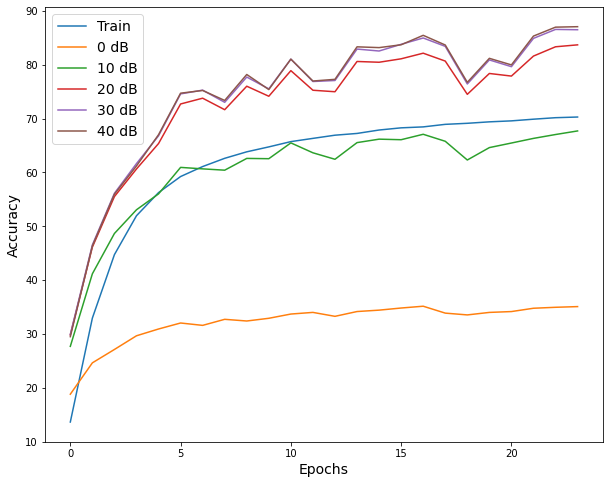

In [36]:
import matplotlib.pyplot as plt
ep = range(0, 24)
plt.figure(figsize=(10, 8))
plt.plot(ep, acc_res["training"], label='Train')
plt.plot(ep, acc_res[0], label='0 dB')
plt.plot(ep, acc_res[10], label='10 dB')
plt.plot(ep, acc_res[20], label='20 dB')
plt.plot(ep, acc_res[30], label='30 dB')
plt.plot(ep, acc_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)
plt.savefig("DOA3_resnet34")
plt.show()

In [36]:
def train():
    print("Training Starts !!!!!!!")
    for i in range(50):
        training_loss = 0
        tcorrect = 0
        ttotal = 0
        epoch_loss = 0.0
        training_mae = 0.0
        for data in range(0, len(train_dataset_list)):
            classification_model.train()
            for j,(features, labels) in enumerate(train_dataset_list[data], 0):
                features, labels = Variable(features.cuda()), Variable(labels.cuda())
                optimizer.zero_grad()
                enn = classification_model(features.float())
                auto_outputs = torch.transpose(enn, 2, 3)
                auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, 2))
                losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
                losss.backward()
                optimizer.step()
#                 exp_scheduler.step()
                training_loss += losss.item()
                _, pred = torch.max(auto_outputs, 1)
                ttotal+= labels.reshape(-1).size(0)
                tcorrect+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                epoch_loss += auto_outputs.shape[0] * losss.item()
                training_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()
                if i % 2000 == 1999:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' % (i + 1, j + 1, training_loss / 2000))
                    training_loss = 0.0
#         wandb.log({"Trainig Acc":(100*(tcorrect/ttotal)), "Traningloss":(training_loss/len(train_dataset_list[data]))})
        tr.append((100*(tcorrect/ttotal)))
        print("Epoch {}  \nTraningloss: {}".format(i+1, training_loss/len(train_dataset_list[data])), " ---- Trainig Acc: {}".format( 100*(tcorrect/ttotal)), " ---- Trainig MAE: {}".format( training_mae/len(train_dataset_list[data])))
            
        classification_model.eval()
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            validation_mae = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    auto_outputs = torch.transpose(enn, 2, 3)
                    auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, 2))
                    loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

                    _, pred = torch.max(auto_outputs, 1)
                    total+= labels.reshape(-1).size(0)
                    correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
                    validation_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()
#             wandb.log({"Validation Acc "+str(val_data):(100*(correct/total)),"Validation Loss "+str(val_data):( validation_loss/len(test_dataset_list[val_data]))})
            print(val_data*10, "dB SNR is validated")
            vl1[val_data].append((100*(correct/total)))
            print("Validationloss: {}".format( validation_loss/len(test_dataset_list[val_data])), " ---- Validation Acc: {}".format(100*(correct/total)))
        print("\n")  
        ep.append(i)
#     wandb.finish()
		

train()
print("Training Complete")

Training Starts !!!!!!!
Epoch 1  
Traningloss: 11.172455108538534  ---- Trainig Acc: 30.539333333333335  ---- Trainig MAE: 6861.07960199005
0 dB SNR is validated
Validationloss: 9.63906729221344  ---- Validation Acc: 2.8000000000000003
10 dB SNR is validated
Validationloss: 2.5954620599746705  ---- Validation Acc: 30.964999999999996
20 dB SNR is validated
Validationloss: 2.3270887970924377  ---- Validation Acc: 42.83
30 dB SNR is validated
Validationloss: 3.5884485721588133  ---- Validation Acc: 33.18
40 dB SNR is validated
Validationloss: 1.3054748833179475  ---- Validation Acc: 51.66


Epoch 2  
Traningloss: 5.574595889027608  ---- Trainig Acc: 59.10411111111111  ---- Trainig MAE: 2529.500355366027
0 dB SNR is validated
Validationloss: 14.622581911087035  ---- Validation Acc: 4.52
10 dB SNR is validated
Validationloss: 2.1429899990558625  ---- Validation Acc: 50.68
20 dB SNR is validated
Validationloss: 1.1617761239409448  ---- Validation Acc: 70.91
30 dB SNR is validated
Validationl

KeyboardInterrupt: 

In [24]:
#ResNet34
max(vl1[0]), max(vl1[1]), max(vl1[2]), max(vl1[3]), max(vl1[4]) 

(62.22, 91.14, 97.46000000000001, 98.9, 99.64)

In [1]:
#ResNet34
max(vl1[0]), max(vl1[1]), max(vl1[2]), max(vl1[3]), max(vl1[4]) 

NameError: name 'vl1' is not defined

In [22]:
#ResNet 101
max(vl1[0]), max(vl1[1]), max(vl1[2]), max(vl1[3]), max(vl1[4]) 

(63.72, 91.5, 97.96000000000001, 99.0, 99.58)

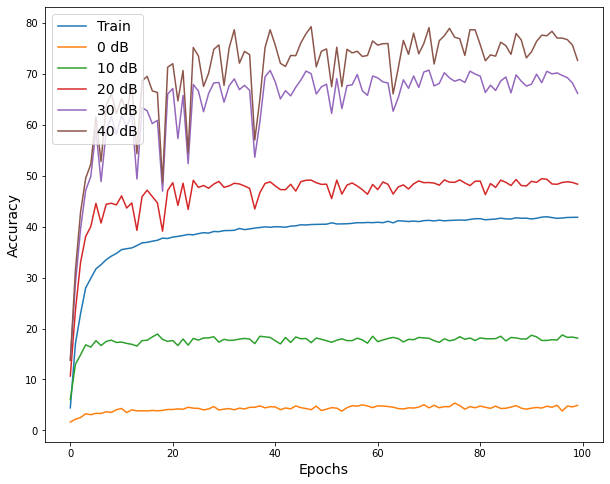

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.plot(ep, tr, label='Train')
plt.plot(ep, vl1[0], label='0 dB')
plt.plot(ep, vl1[1], label='10 dB')
plt.plot(ep, vl1[2], label='20 dB')
plt.plot(ep, vl1[3], label='30 dB')
plt.plot(ep, vl1[4], label='40 dB')
# plt.plot(ep, vl1[5], label='50 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)
plt.savefig("8_resnet34")
plt.show()

# SNS DOA - 3

In [2]:
import scipy.io as sio
import numpy as np
import torch
import os
from os import listdir
from os.path import isfile, join
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np 
import math
import pandas as pd
import cmath
import scipy.io as sio
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import math
import pandas as pd
import cmath

#from unet import UNet
# from auto import encoder, decoder

from collections import OrderedDict
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
#==========================================================================
# For Plotting loss graph
# Bokeh
from bokeh.io import curdoc
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

from functools import partial
from threading import Thread
from tornado import gen
# from AttRCNN_UNet import Att_R2U
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
import sys
# from dataloader import norm
import csv
from sklearn.model_selection import train_test_split
from sys import getsizeof
# import wandb
# import logging
# logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu2(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=181):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=(1,3), stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=1)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=1)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=1)
        self.linear = nn.Linear(100, 80)
        self.linear1 = nn.Linear(80, num_classes)
        self.adp_pool = nn.AdaptiveMaxPool2d((3, 100))
        #self.flat = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1)
        self.flat = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1)
        self.dropout = nn.Dropout(0.7)
        self.dropout1 = nn.Dropout(0.6)
        self.relu = nn.ReLU(inplace=True)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # print("Input ==> ", x.size())
        out = self.relu(self.bn1(self.conv1(x)))
        # print("F.relu(self.bn1(self.conv1(x))) ==> ", x.size())
        out = self.layer1(out)
        # print("layer1 ==> ", x.size())
        out = self.layer2(out)
        # print("layer2 ==> ", x.size())
        out = self.layer3(out)
        # print("layer3 ==> ", x.size())
        out = self.layer4(out)
        out = self.dropout(out)
#         print("layer4 ==>", out.size())
        out = self.adp_pool(out)
        
        out = self.linear(out)
        out = self.dropout1(out)
        out = F.relu(out)
        out = self.linear1(out)
        out = self.flat(out)
#         print("Out ===>", out.size())
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [2, 3, 5, 2])

def ResNet101():
    return ResNet(BasicBlock, [3, 4, 23, 3])


if __name__ == "__main__":
    image = torch.rand(1, 3, 10, 100)
    model = ResNet34()
    print(model(image).size())


torch.Size([1, 1, 3, 181])


In [22]:
def norm(df):
    # print(df["DOA"].shape)
    # print(df['NS_data'].shape)
    transp = np.transpose(df['SNS_data'], (2, 0, 1))
    new = np.zeros((100000, 3, 8, 10))
    for i in range(0, transp.shape[0]):
        for j in range(0, transp.shape[1]):
            for k in range(0, transp.shape[2]):
                new[i][0][j][k] = transp[i][j][k].real
                new[i][1][j][k] = transp[i][j][k].imag
                new[i][2][j][k] = cmath.phase(transp[i][j][k])

    max_r =  -10000000000000
    min_r = 10000000000000
    max_i =  -10000000000000
    min_i = 10000000000000
    max_p =  -10000000000000
    min_p = 10000000000000

    for i in range(0, new.shape[0]):
        for j in range(0, new.shape[1]):
            for k in range(0, new.shape[2]):
                if new[i][0][j][k] > max_r :
                    max_r = new[i][0][j][k]
                if new[i][0][j][k] < min_r:
                    min_r = new[i][0][j][k]
                if new[i][1][j][k] > max_i :
                    max_i = new[i][1][j][k]
                if new[i][1][j][k] < min_i:
                    min_i = new[i][1][j][k]
                if new[i][2][j][k] > max_p :
                    max_p = new[i][2][j][k]
                if new[i][2][j][k] < min_p:
                    min_p = new[i][2][j][k]
    print("St")
    print(max_r, max_i, max_p, min_r, min_i, min_p)

    ll = []
    ll.append(max_r)
    ll.append(max_i)
    ll.append(max_p)
    ll.append(min_r)
    ll.append(min_i)
    ll.append(min_p)
    return ll

# import glob

# files = glob.glob("../SNS_dataset/DOA3/*.mat")
# for i in files:
#     norm(i)

In [4]:
train_dataset_list = []
test_dataset_list = []

In [21]:
data_list = [os.path.join(root_dataset_path, f) for f in listdir(root_dataset_path) if isfile(join(root_dataset_path, f))]
set(data_list)

{'../SNS_dataset/400/DOA3/SNR_SNS_00_3_400.mat',
 '../SNS_dataset/400/DOA3/SNR_SNS_10_3_400.mat',
 '../SNS_dataset/400/DOA3/SNR_SNS_20_3_400.mat',
 '../SNS_dataset/400/DOA3/SNR_SNS_30_3_400.mat',
 '../SNS_dataset/400/DOA3/SNR_SNS_40_3_400.mat'}

In [4]:
root_dataset_path  = ("../SNS_dataset/400/DOA3")
data_list = [os.path.join(root_dataset_path, f) for f in listdir(root_dataset_path) if isfile(join(root_dataset_path, f))]
data_list = set(data_list)
df = [sio.loadmat(path) for path in data_list]

In [5]:
len(df)

5

In [6]:
data_list

{'../SNS_dataset/400/DOA3/SNR_SNS_00_3_400.mat',
 '../SNS_dataset/400/DOA3/SNR_SNS_10_3_400.mat',
 '../SNS_dataset/400/DOA3/SNR_SNS_20_3_400.mat',
 '../SNS_dataset/400/DOA3/SNR_SNS_30_3_400.mat',
 '../SNS_dataset/400/DOA3/SNR_SNS_40_3_400.mat'}

In [7]:
from sklearn.model_selection import train_test_split
new_train_dataset_list = []
new_test_dataset_list = []
train_dataset_list_label = []
test_dataset_list_label = []
def create_dataset(df):
    data = np.transpose(df['SNS_data'], (2, 0, 1))
    label = df['DOA']
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.15, random_state=42)
    new_train_dataset_list.extend(X_train)
    new_test_dataset_list.append(X_test.tolist())
    train_dataset_list_label.extend(y_train)
    test_dataset_list_label.append(y_test.tolist())
    
for file in df:
    create_dataset(file)

In [8]:
del df

In [43]:
# norm_list = [norm(i) for i in df]

In [9]:
# for idx, data in enumerate(new_train_dataset_list):
#     max_r = max(norm_list[0][0], norm_list[1][0], norm_list[2][0], norm_list[3][0], norm_list[4][0])
#     max_i = max(norm_list[0][1], norm_list[1][1], norm_list[2][1], norm_list[3][1], norm_list[4][1])
#     max_p = max(norm_list[0][2], norm_list[1][2], norm_list[2][2], norm_list[3][2], norm_list[4][2])
#     min_r = min(norm_list[0][3], norm_list[1][3], norm_list[2][3], norm_list[3][3], norm_list[4][3])
#     min_i = min(norm_list[0][4], norm_list[1][4], norm_list[2][4], norm_list[3][4], norm_list[4][4])
#     min_p = min(norm_list[0][5], norm_list[1][5], norm_list[2][5], norm_list[3][5], norm_list[4][5])
# #     print(type((data[0][0])))
#     new = np.zeros((3, 8, 10))
# #     print(type(new[0][0][0]))
#     for j in range(0, data.shape[0]):
#         for k in range(0, data.shape[1]):
#             new[0][j][k] =  (data[j][k].real  - min_r)/(max_r-min_r)
#             new[1][j][k] =  (data[j][k].imag - min_i)/(max_i-min_i)
#             new[2][j][k] = (cmath.phase(data[j][k]) - min_p)/ (max_p - min_p)
#     new_train_dataset_list[idx] = new
    
# for idx, data in enumerate(new_test_dataset_list):
#     for i, ndata in enumerate(data):
#         max_r = max(norm_list[0][0], norm_list[1][0], norm_list[2][0], norm_list[3][0], norm_list[4][0])
#         max_i = max(norm_list[0][1], norm_list[1][1], norm_list[2][1], norm_list[3][1], norm_list[4][1])
#         max_p = max(norm_list[0][2], norm_list[1][2], norm_list[2][2], norm_list[3][2], norm_list[4][2])
#         min_r = min(norm_list[0][3], norm_list[1][3], norm_list[2][3], norm_list[3][3], norm_list[4][3])
#         min_i = min(norm_list[0][4], norm_list[1][4], norm_list[2][4], norm_list[3][4], norm_list[4][4])
#         min_p = min(norm_list[0][5], norm_list[1][5], norm_list[2][5], norm_list[3][5], norm_list[4][5])
#         new = np.zeros((3, 8, 10))
#         for j in range(0, 8):
#             for k in range(0, 10):
#                 new[0][j][k] =  (ndata[j][k].real  - min_r)/(max_r-min_r)
#                 new[1][j][k] =  (ndata[j][k].imag - min_i)/(max_i-min_i)
#                 new[2][j][k] = (cmath.phase(ndata[j][k]) - min_p)/ (max_p - min_p)
#         new_test_dataset_list[idx][i] = new

for idx, data in enumerate(new_train_dataset_list):
    new = np.zeros((3, 8, 40))
    for j in range(0, data.shape[0]):
        for k in range(0, data.shape[1]):
            new[0][j][k] = data[j][k].real
            new[1][j][k] = data[j][k].imag
            new[2][j][k] = cmath.phase(data[j][k])
    new_train_dataset_list[idx] = new
    
for idx, data in enumerate(new_test_dataset_list):
    for i, ndata in enumerate(data):
        new = np.zeros((3, 8, 40))
        for j in range(0, 8):
            for k in range(0, 40):
                new[0][j][k] = ndata[j][k].real
                new[1][j][k] = ndata[j][k].imag
                new[2][j][k] = cmath.phase(ndata[j][k])
        new_test_dataset_list[idx][i] = new

In [10]:
def get_data(train, test, batch_size, train_bool=True):
    class DOA_dataset(Dataset):
        def __init__(self, train, test):
            self.x = torch.from_numpy(np.array(train))
            self.y = torch.from_numpy(np.asarray(test))
            self.n_sample = len(self.y)
        def __getitem__(self, index):
            return self.x[index], self.y[index]
        def __len__(self):
            return self.n_sample

    dataset = DOA_dataset(train, test)

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train_bool)
    return loader


In [11]:
doa2_train_loader = get_data(new_train_dataset_list, train_dataset_list_label, 64, True)

In [12]:
del new_train_dataset_list
del train_dataset_list_label

In [13]:
test_dataset_list = []
for idx, data in enumerate(new_test_dataset_list):
    print(type(data))
    f = get_data(data, test_dataset_list_label[idx], 128, False)
    test_dataset_list.append(f)

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [14]:
del new_test_dataset_list
del new

In [15]:
num_epochs = 60
doa = 3
weights_dir = "./doa_weights/"

autoencoder = ResNet34()
criterion = nn.CrossEntropyLoss()
if ('SNS_DOA_{}_400_model.pth'.format(doa) in [f for f in listdir(weights_dir) if isfile(join(weights_dir, f))]):
    print("Pre-trained available for DOA_{}_model.pth".format(doa))
    autoencoder = torch.load(os.path.join(weights_dir, 'SNS_DOA_{}_400_model.pth'.format(doa)))

if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))
	classification_model = autoencoder.cuda()
	optimizer = optim.AdamW(classification_model.parameters(), lr=0.0001, weight_decay=1e-5)
	criterion = criterion.cuda()

Pre-trained available for DOA_3_model.pth
GeForce GTX 1080 Ti


In [17]:
acc_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
loss_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
mae_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}

In [18]:
def train():
    print("Training Starts !!!!!!!")
    best_valid_loss = float('Inf')
    for i in range(num_epochs):
        training_loss = 0
        train_correct = 0
        train_total = 0
        epoch_loss = 0.0
        training_mae = 0.0
        classification_model.train()
        for j,(features, labels) in enumerate(doa2_train_loader, 0):
            features, labels = Variable(features.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            enn = classification_model(features.float())
            auto_outputs = torch.transpose(enn, 2, 3)
            auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, 3))
            losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
            losss.backward()
            optimizer.step()
#           exp_scheduler.step()
            training_loss += losss.item()

            _, pred = torch.max(auto_outputs, 1)

            train_total+= labels.reshape(-1).size(0)

            train_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()

            epoch_loss += auto_outputs.shape[0] * losss.item()
            training_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()  

        loss_res['training'].append(training_loss/len(doa2_train_loader))
        acc_res['training'].append((100*(train_correct/train_total)))

        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}, Training MAE: {}'
                      .format(i+1, num_epochs, training_loss/len(doa2_train_loader), (100*(train_correct/train_total)), training_mae/(len(doa2_train_loader)*64*181)))
        
        # Validation for each SNR value
        classification_model.eval()
        total_valdation_loss = 0
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            validation_acc = 0
            validation_mae = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    auto_outputs = torch.transpose(enn, 2, 3)
                    auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, 3))
                    loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

                    _, pred = torch.max(auto_outputs, 1)
                    val_total+= labels.reshape(-1).size(0)
                    val_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
                    validation_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()

                loss_res[10*val_data].append(validation_loss/len(test_dataset_list[val_data]))
                acc_res[10*val_data].append((100*(val_correct/val_total)))
                print('SNR [{}dB], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}, Validation MAE: {}'
                      .format(val_data*10, validation_loss/len(test_dataset_list[val_data]), (100*(val_correct/val_total)), validation_mae/(len(test_dataset_list[val_data])*128*181)))

                total_valdation_loss+=validation_loss
            torch.save( classification_model, weights_dir+ "/SNS_DOA_{}_400_model.pth".format(doa))
            if best_valid_loss > total_valdation_loss:
                best_valid_loss = total_valdation_loss 
                # Saving Best Pre-Trained Model as .pth file
                torch.save( classification_model, weights_dir+ "/DOA_{}_400_best_model.pth".format(doa))
#         if i%10 == 0:
#           ddf = pd.DataFrame(acc_res)
#           ddf.to_csv(weights_dir+"res_DOA_{}_model.csv".format(doa))
        print("\n")  

train()
print("Training Complete")

Training Starts !!!!!!!
Epoch [1/60], Training Loss: 1.0794, Training Accuracy: 62.4129, Training MAE: 0.05736498935958689
SNR [0dB], Validation Loss: 0.8849, Validation Accuracy: 70.0044, Validation MAE: 0.027874508380934544
SNR [10dB], Validation Loss: 2.9553, Validation Accuracy: 21.2978, Validation MAE: 0.16718998735836688
SNR [20dB], Validation Loss: 0.6630, Validation Accuracy: 77.8311, Validation MAE: 0.020193692059181572
SNR [30dB], Validation Loss: 0.6290, Validation Accuracy: 78.9311, Validation MAE: 0.01824404204513531
SNR [40dB], Validation Loss: 1.6725, Validation Accuracy: 48.1622, Validation MAE: 0.05887211466429441


Epoch [2/60], Training Loss: 1.0616, Training Accuracy: 63.0395, Training MAE: 0.056637893597532823
SNR [0dB], Validation Loss: 0.8369, Validation Accuracy: 69.7333, Validation MAE: 0.029621877633673566
SNR [10dB], Validation Loss: 2.8680, Validation Accuracy: 22.0044, Validation MAE: 0.16511852994194212
SNR [20dB], Validation Loss: 0.6258, Validation Accur

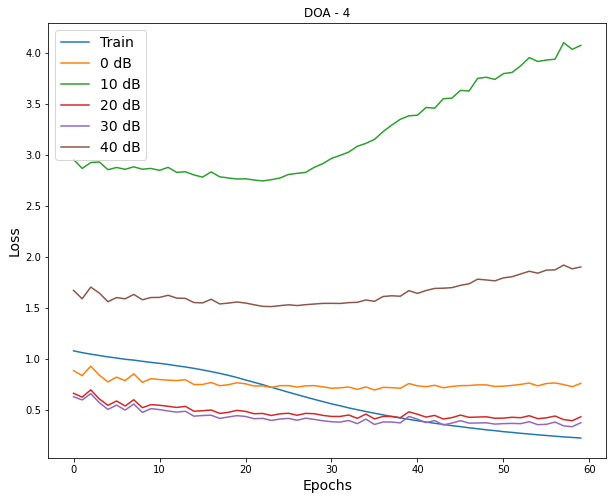

In [19]:
import matplotlib.pyplot as plt
ep = range(0, len(loss_res["training"]))
plt.figure(figsize=(10, 8))
plt.plot(ep, loss_res["training"], label='Train')
plt.plot(ep, loss_res[0], label='0 dB')
plt.plot(ep, loss_res[10], label='10 dB')
plt.plot(ep, loss_res[20], label='20 dB')
plt.plot(ep, loss_res[30], label='30 dB')
plt.plot(ep, loss_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("DOA - 4")
plt.legend(fontsize=14)
plt.savefig("DOA3_resnet34")
plt.show()

In [22]:
print(max(acc_res[0]), max(acc_res[10]), max(acc_res[20]), max(acc_res[30]), max(acc_res[40]))
print(min(loss_res[0]), min(loss_res[10]), min(loss_res[20]), min(loss_res[30]), min(loss_res[40]))

74.58444444444444 22.282222222222224 84.93555555555555 87.27111111111111 50.28888888888889
0.6951736924001726 2.7453948724067816 0.3944039764040608 0.33552125475164185 1.5133821691496898


# DOA4

In [2]:
import scipy.io as sio
import numpy as np
import torch
import os
from os import listdir
from os.path import isfile, join
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np 
import math
import pandas as pd
import cmath
import scipy.io as sio
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import math
import pandas as pd
import cmath

#from unet import UNet
# from auto import encoder, decoder

from collections import OrderedDict
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
#==========================================================================
# For Plotting loss graph
# Bokeh
from bokeh.io import curdoc
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

from functools import partial
from threading import Thread
from tornado import gen
# from AttRCNN_UNet import Att_R2U
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
import sys
# from dataloader import norm
import csv
from sklearn.model_selection import train_test_split
from sys import getsizeof
# import wandb
# import logging
# logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

In [154]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu2(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=181):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=(1,3), stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=1)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=1)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=1)
        self.linear = nn.Linear(25, num_classes)
        self.adp_pool = nn.AdaptiveMaxPool2d((4, 25))
        #self.flat = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1)
        self.flat = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1)
        self.dropout = nn.Dropout(0.4)
        self.dropout = nn.Dropout(0.4)
        self.relu = nn.ReLU(inplace=True)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # print("Input ==> ", x.size())
        out = self.relu(self.bn1(self.conv1(x)))
        # print("F.relu(self.bn1(self.conv1(x))) ==> ", x.size())
        out = self.layer1(out)
        # print("layer1 ==> ", x.size())
        out = self.layer2(out)
        # print("layer2 ==> ", x.size())
        out = self.layer3(out)
        # print("layer3 ==> ", x.size())
        out = self.dropout(out)
        out = self.layer4(out)
        out = self.dropout(out)
#         print("layer4 ==>", out.size())
        out = self.adp_pool(out)
        
#         print("avg_pool2d ===>", out.size())
        # out = out.view(out.size(0), -1)
        # print("out.view ===>", out.size())
        out = self.linear(out)
        out = self.dropout(out)
        out = self.flat(out)
#         print("Out ===>", out.size())
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [2, 3, 5, 2])

def ResNet101():
    return ResNet(BasicBlock, [3, 4, 23, 3])


if __name__ == "__main__":
    image = torch.rand(1, 3, 10, 100)
    model = ResNet34()
    model(image)


In [1]:
# def norm(df):
#     # print(df["DOA"].shape)
#     # print(df['NS_data'].shape)
#     transp = np.transpose(df['SNS_data'], (2, 0, 1))
#     new = np.zeros((100000, 3, 8, 10))
#     for i in range(0, transp.shape[0]):
#         for j in range(0, transp.shape[1]):
#             for k in range(0, transp.shape[2]):
#                 new[i][0][j][k] = transp[i][j][k].real
#                 new[i][1][j][k] = transp[i][j][k].imag
#                 new[i][2][j][k] = cmath.phase(transp[i][j][k])

#     max_r =  -10000000000000
#     min_r = 10000000000000
#     max_i =  -10000000000000
#     min_i = 10000000000000
#     max_p =  -10000000000000
#     min_p = 10000000000000

#     for i in range(0, new.shape[0]):
#         for j in range(0, new.shape[1]):
#             for k in range(0, new.shape[2]):
#                 if new[i][0][j][k] > max_r :
#                     max_r = new[i][0][j][k]
#                 if new[i][0][j][k] < min_r:
#                     min_r = new[i][0][j][k]
#                 if new[i][1][j][k] > max_i :
#                     max_i = new[i][1][j][k]
#                 if new[i][1][j][k] < min_i:
#                     min_i = new[i][1][j][k]
#                 if new[i][2][j][k] > max_p :
#                     max_p = new[i][2][j][k]
#                 if new[i][2][j][k] < min_p:
#                     min_p = new[i][2][j][k]
#     print("St")
#     print(max_r, max_i, max_p, min_r, min_i, min_p)

#     ll = []
#     ll.append(max_r)
#     ll.append(max_i)
#     ll.append(max_p)
#     ll.append(min_r)
#     ll.append(min_i)
#     ll.append(min_p)
#     return ll

# # import glob

# # files = glob.glob("../SNS_dataset/DOA3/*.mat")
# # for i in files:
# #     norm(i)

In [178]:
train_dataset_list = []
test_dataset_list = []

In [179]:
df1  = sio.loadmat("../SNS_dataset/DOA4/SNR_SNS_00_4.mat")
df2  = sio.loadmat("../SNS_dataset/DOA4/SNR_SNS_10_4.mat")
df3  = sio.loadmat("../SNS_dataset/DOA4/SNR_SNS_20_4.mat")
df4  = sio.loadmat("../SNS_dataset/DOA4/SNR_SNS_30_4.mat")
df5  = sio.loadmat("../SNS_dataset/DOA4/SNR_SNS_40_4.mat")
df = [df1, df2, df3, df4, df5]

In [180]:
# norm_list = [norm(i) for i in df]

In [181]:
from sklearn.model_selection import train_test_split
new_train_dataset_list = []
new_test_dataset_list = []
train_dataset_list_label = []
test_dataset_list_label = []
def create_dataset(df):
    data = np.transpose(df['SNS_data'], (2, 0, 1))
    label = df['DOA']
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.15, random_state=42)
    new_train_dataset_list.extend(X_train)
    new_test_dataset_list.append(X_test.tolist())
    train_dataset_list_label.extend(y_train)
    test_dataset_list_label.append(y_test.tolist())
    
for file in df:
    create_dataset(file)

In [182]:
del df
del df1
del df2
del df3
del df4
del df5

In [183]:
for idx, data in enumerate(new_train_dataset_list):
    new = np.zeros((3, 8, 10))
    for j in range(0, data.shape[0]):
        for k in range(0, data.shape[1]):
            new[0][j][k] = data[j][k].real
            new[1][j][k] = data[j][k].imag
            new[2][j][k] = cmath.phase(data[j][k])
    new_train_dataset_list[idx] = new
    
for idx, data in enumerate(new_test_dataset_list):
    for i, ndata in enumerate(data):
        new = np.zeros((3, 8, 10))
        for j in range(0, 8):
            for k in range(0, 10):
                new[0][j][k] = ndata[j][k].real
                new[1][j][k] = ndata[j][k].imag
                new[2][j][k] = cmath.phase(ndata[j][k])
        new_test_dataset_list[idx][i] = new

In [184]:
def get_data(train, test, batch_size, train_bool=True):
    class DOA_dataset(Dataset):
        def __init__(self, train, test):
            self.x = torch.from_numpy(np.array(train))
            self.y = torch.from_numpy(np.asarray(test))
            self.n_sample = len(self.y)
        def __getitem__(self, index):
            return self.x[index], self.y[index]
        def __len__(self):
            return self.n_sample

    dataset = DOA_dataset(train, test)

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train_bool)
    return loader


In [185]:
doa2_train_loader = get_data(new_train_dataset_list, train_dataset_list_label, 64, True)

In [186]:
del new_train_dataset_list
del train_dataset_list_label

In [187]:
test_dataset_list = []
for idx, data in enumerate(new_test_dataset_list):
    print(type(data))
    f = get_data(data, test_dataset_list_label[idx], 128, False)
    test_dataset_list.append(f)

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [188]:
del new_test_dataset_list
del new

In [189]:
num_epochs = 60
doa = 4
weights_dir = "./doa_weights/SNS/"

autoencoder = ResNet34()
criterion = nn.CrossEntropyLoss()
# if ('SNS_DOA_{}_model.pth'.format(doa) in [f for f in listdir(weights_dir) if isfile(join(weights_dir, f))]):
#     print("Pre-trained available for DOA_{}_model.pth".format(doa))
#     autoencoder = torch.load(os.path.join(weights_dir, 'SNS_DOA_{}_model.pth'.format(doa)))

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    classification_model = autoencoder.cuda()
    optimizer = optim.AdamW(classification_model.parameters(), lr=0.001, weight_decay=1e-5)
    exp_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma = 0.1)
    criterion = criterion.cuda()

GeForce GTX 1080 Ti


In [190]:
# Saved_dataloader_dir = "./saved_dataloader/"
# # doa = 6
# # np.savez(Saved_dataloader_dir+ "/SNS_DOA_{}_trainloader.pth".format(doa), doa2_train_loader, test_dataset_list)
# torch.save( doa2_train_loader, Saved_dataloader_dir+ "/SNS_DOA_{}_trainloader.pth".format(doa))
# torch.save( test_dataset_list, Saved_dataloader_dir+ "/SNS_DOA_{}_testloaderList.pth".format(doa))

In [191]:
acc_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
loss_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
mae_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}

In [192]:
def train():
    print("Training Starts !!!!!!!")
    best_valid_loss = float('Inf')
    for i in range(num_epochs):
        training_loss = 0
        train_correct = 0
        train_total = 0
        epoch_loss = 0.0
        training_mae = 0.0
        classification_model.train()
        for j,(features, labels) in enumerate(doa2_train_loader, 0):
            features, labels = Variable(features.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            enn = classification_model(features.float())
            auto_outputs = torch.transpose(enn, 2, 3)
            auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, 4))
            losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
            nn.utils.clip_grad_value_(classification_model.parameters(), clip_value=5.0)
            losss.backward()
            optimizer.step()
            exp_scheduler.step()
            training_loss += losss.item()

            _, pred = torch.max(auto_outputs, 1)

            train_total+= labels.reshape(-1).size(0)

            train_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()

            epoch_loss += auto_outputs.shape[0] * losss.item()
            training_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()  

        loss_res['training'].append(training_loss/len(doa2_train_loader))
        acc_res['training'].append((100*(train_correct/train_total)))
        mae_res['training'].append(training_mae/(128*len(doa2_train_loader)*181))
        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}, Training MAE: {}'
                      .format(i+1, num_epochs, training_loss/len(doa2_train_loader), (100*(train_correct/train_total)), training_mae/(128*len(doa2_train_loader)*181)))
        
        # Validation for each SNR value
        classification_model.eval()
        total_valdation_loss = 0
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            validation_acc = 0
            validation_mae = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    auto_outputs = torch.transpose(enn, 2, 3)
                    auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, 4))
                    loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

                    _, pred = torch.max(auto_outputs, 1)
                    val_total+= labels.reshape(-1).size(0)
                    val_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
                    validation_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()

                loss_res[10*val_data].append(validation_loss/len(test_dataset_list[val_data]))
                acc_res[10*val_data].append((100*(val_correct/val_total)))
                mae_res[10*val_data].append(validation_mae/(128*len(test_dataset_list[val_data])*181))
                
                print('SNR [{}dB], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}, Validation MAE: {}'
                      .format(val_data*10, validation_loss/len(test_dataset_list[val_data]), (100*(val_correct/val_total)), validation_mae/(128*len(test_dataset_list[val_data])*181)))

                total_valdation_loss+=validation_loss
            torch.save( classification_model, weights_dir+ "/SNS_DOA_{}_model.pth".format(doa))
            if best_valid_loss > total_valdation_loss:
                best_valid_loss = total_valdation_loss 
                # Saving Best Pre-Trained Model as .pth file
                torch.save( classification_model, weights_dir+ "/DOA_{}_best_model.pth".format(doa))
#         if i%10 == 0:
#           ddf = pd.DataFrame(acc_res)
#           ddf.to_csv(weights_dir+"res_DOA_{}_model.csv".format(doa))
        print("\n")  

train()
print("Training Complete")

Training Starts !!!!!!!
Epoch [1/60], Training Loss: 5.3071, Training Accuracy: 0.5658, Training MAE: 0.7062580307457191
SNR [0dB], Validation Loss: 5.2039, Validation Accuracy: 0.5700, Validation MAE: 1.5425148070980428
SNR [10dB], Validation Loss: 5.2038, Validation Accuracy: 0.5317, Validation MAE: 1.5713853561897182
SNR [20dB], Validation Loss: 5.2043, Validation Accuracy: 0.5650, Validation MAE: 1.586643470830602
SNR [30dB], Validation Loss: 5.2044, Validation Accuracy: 0.5383, Validation MAE: 1.5895233197162655
SNR [40dB], Validation Loss: 5.2034, Validation Accuracy: 0.5833, Validation MAE: 1.5822229229094484


Epoch [2/60], Training Loss: 5.3035, Training Accuracy: 0.5599, Training MAE: 0.705845866825538
SNR [0dB], Validation Loss: 5.2046, Validation Accuracy: 0.5667, Validation MAE: 1.550380346357337
SNR [10dB], Validation Loss: 5.2046, Validation Accuracy: 0.5167, Validation MAE: 1.578505419514936
SNR [20dB], Validation Loss: 5.2053, Validation Accuracy: 0.5550, Validation MA

KeyboardInterrupt: 

In [92]:
max(acc_res[0]), max(acc_res[10]), max(acc_res[20]), max(acc_res[30]), max(acc_res[40])

(8.401666666666667, 25.705, 52.21, 72.37333333333333, 79.445)

In [93]:
min(mae_res[0]), min(mae_res[10]), min(mae_res[20]), min(mae_res[30]), min(mae_res[40])

(0.4132994662421575,
 0.1497748209101976,
 0.05967757982957206,
 0.029512141235134376,
 0.021340803211911227)

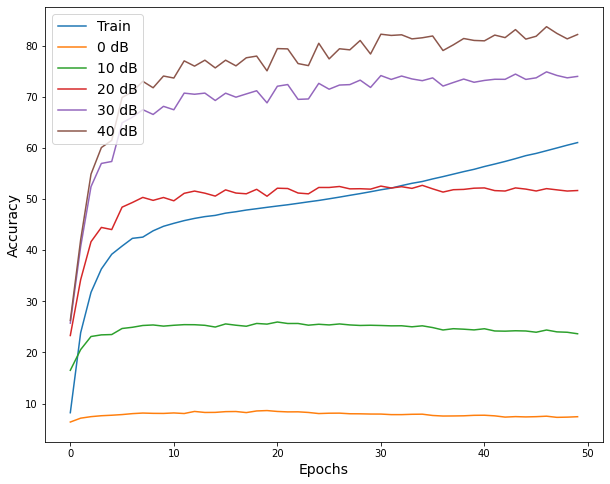

In [64]:
import matplotlib.pyplot as plt
ep = range(0, len(acc_res["training"]))
plt.figure(figsize=(10, 8))
plt.plot(ep, acc_res["training"], label='Train')
plt.plot(ep, acc_res[0], label='0 dB')
plt.plot(ep, acc_res[10], label='10 dB')
plt.plot(ep, acc_res[20], label='20 dB')
plt.plot(ep, acc_res[30], label='30 dB')
plt.plot(ep, acc_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)
plt.savefig("DOA3_resnet34")
plt.show()

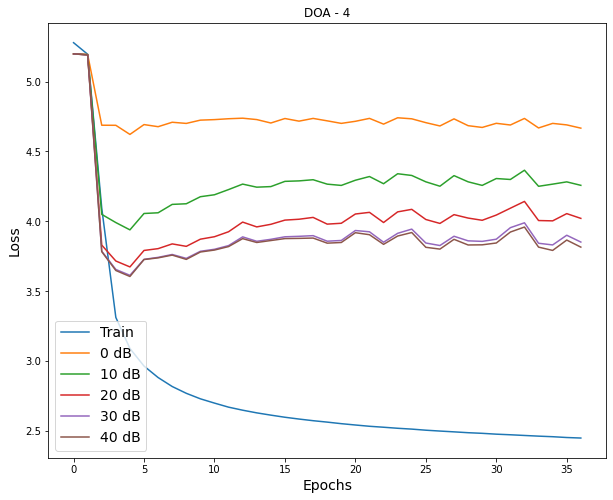

In [85]:
import matplotlib.pyplot as plt
ep = range(0, len(loss_res["training"]))
plt.figure(figsize=(10, 8))
plt.plot(ep, loss_res["training"], label='Train')
plt.plot(ep, loss_res[0], label='0 dB')
plt.plot(ep, loss_res[10], label='10 dB')
plt.plot(ep, loss_res[20], label='20 dB')
plt.plot(ep, loss_res[30], label='30 dB')
plt.plot(ep, loss_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("DOA - 4")
plt.legend(fontsize=14)
plt.savefig("DOA3_resnet34")
plt.show()

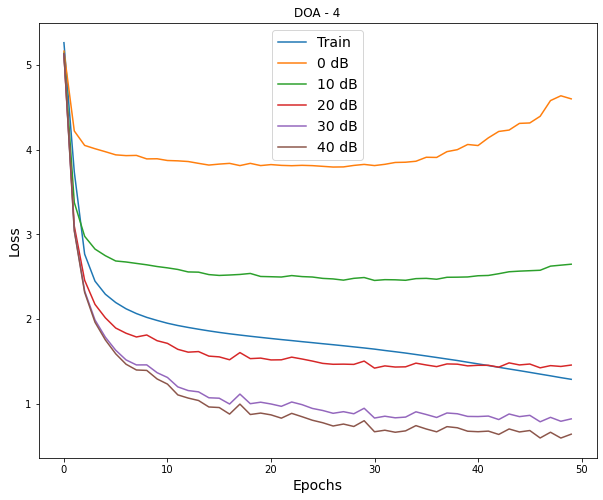

In [153]:
import matplotlib.pyplot as plt
ep = range(0, len(loss_res["training"]))
plt.figure(figsize=(10, 8))
plt.plot(ep, loss_res["training"], label='Train')
plt.plot(ep, loss_res[0], label='0 dB')
plt.plot(ep, loss_res[10], label='10 dB')
plt.plot(ep, loss_res[20], label='20 dB')
plt.plot(ep, loss_res[30], label='30 dB')
plt.plot(ep, loss_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("DOA - 4")
plt.legend(fontsize=14)
plt.savefig("DOA3_resnet34")
plt.show()

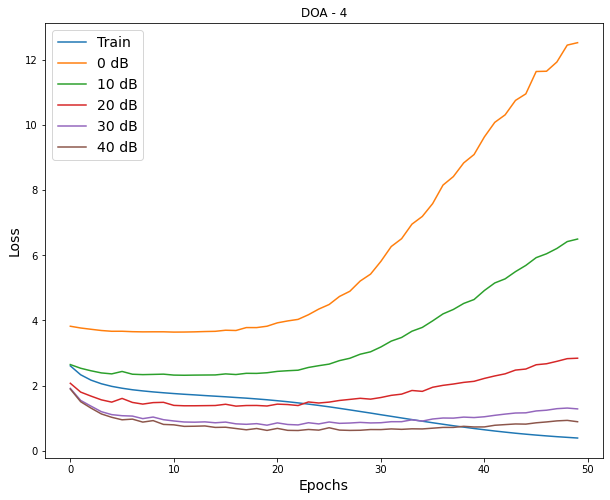

In [65]:
import matplotlib.pyplot as plt
ep = range(0, len(loss_res["training"]))
plt.figure(figsize=(10, 8))
plt.plot(ep, loss_res["training"], label='Train')
plt.plot(ep, loss_res[0], label='0 dB')
plt.plot(ep, loss_res[10], label='10 dB')
plt.plot(ep, loss_res[20], label='20 dB')
plt.plot(ep, loss_res[30], label='30 dB')
plt.plot(ep, loss_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("DOA - 4")
plt.legend(fontsize=14)
plt.savefig("DOA3_resnet34")
plt.show()

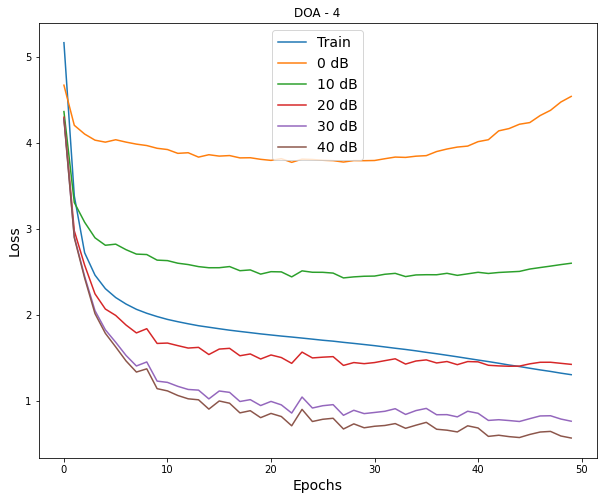

In [91]:
import matplotlib.pyplot as plt
ep = range(0, len(loss_res["training"]))
plt.figure(figsize=(10, 8))
plt.plot(ep, loss_res["training"], label='Train')
plt.plot(ep, loss_res[0], label='0 dB')
plt.plot(ep, loss_res[10], label='10 dB')
plt.plot(ep, loss_res[20], label='20 dB')
plt.plot(ep, loss_res[30], label='30 dB')
plt.plot(ep, loss_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("DOA - 4")
plt.legend(fontsize=14)
plt.savefig("DOA3_resnet34")
plt.show()

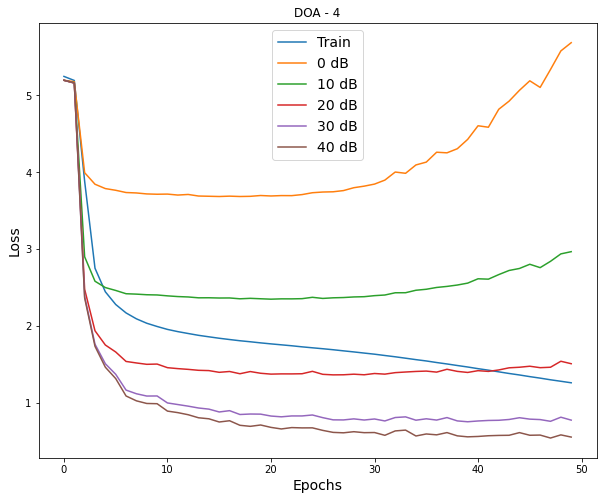

In [99]:
import matplotlib.pyplot as plt
ep = range(0, len(loss_res["training"]))
plt.figure(figsize=(10, 8))
plt.plot(ep, loss_res["training"], label='Train')
plt.plot(ep, loss_res[0], label='0 dB')
plt.plot(ep, loss_res[10], label='10 dB')
plt.plot(ep, loss_res[20], label='20 dB')
plt.plot(ep, loss_res[30], label='30 dB')
plt.plot(ep, loss_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("DOA - 4")
plt.legend(fontsize=14)
plt.savefig("DOA3_resnet34")
plt.show()

In [100]:
weights = "./doa_weights/SNS/SNS_DOA_4_model.pth"

classification_model = torch.load(weights)

criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))
	classification_model = classification_model.cuda()
	optimizer = optim.AdamW(classification_model.parameters(), lr=0.0001, weight_decay=1e-5)
	criterion = criterion.cuda()

GeForce GTX 1080 Ti


In [101]:
import copy
fused_model = copy.deepcopy(classification_model)

In [136]:
classification_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(1, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (relu2): ReLU(inplace=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [137]:
fused_model = torch.quantization.fuse_modules(classification_model,  [['conv1', 'bn1', 'relu']], inplace=True)

In [138]:
class QuantizedResNet18(nn.Module):
    def __init__(self, model_fp32):
        super(QuantizedResNet18, self).__init__()
        # QuantStub converts tensors from floating point to quantized.
        # This will only be used for inputs.
        self.quant = torch.quantization.QuantStub()
        # DeQuantStub converts tensors from quantized to floating point.
        # This will only be used for outputs.
        self.dequant = torch.quantization.DeQuantStub()
        # FP32 model
        self.model_fp32 = model_fp32

    def forward(self, x):
        # manually specify where tensors will be converted from floating
        # point to quantized in the quantized model
        x = self.quant(x)
        x = self.model_fp32(x)
        # manually specify where tensors will be converted from quantized
        # to floating point in the quantized model
        x = self.dequant(x)
        return x

In [139]:
for module_name, module in fused_model.named_children():
        if "layer" in module_name:
            for basic_block_name, basic_block in module.named_children():
                torch.quantization.fuse_modules(basic_block, [["conv1", "bn1", "relu1"], ["conv2", "bn2", "relu2"]], inplace=True)
                for sub_block_name, sub_block in basic_block.named_children():
                    if sub_block_name == "downsample":
                        torch.quantization.fuse_modules(sub_block, [["0", "1"]], inplace=True)

In [140]:
def model_equivalence(model_1, model_2, device, rtol=1e-05, atol=1e-08, num_tests=100, input_size=(1,3,32,32)):

    model_1.to(device)
    model_2.to(device)

    for _ in range(num_tests):
        x = torch.rand(size=input_size).to(device)
        y1 = model_1(x).detach().cpu().numpy()
        y2 = model_2(x).detach().cpu().numpy()
        if np.allclose(a=y1, b=y2, rtol=rtol, atol=atol, equal_nan=False) == False:
            print("Model equivalence test sample failed: ")
            print(y1)
            print(y2)
            return False

In [141]:
# assert model_equivalence(model_1=model, model_2=fused_model, device="cpu", rtol=1e-03, atol=1e-06, num_tests=100, input_size=(1,3,32,32)), "Fused model is not equivalent to the original model!"

In [144]:
 quantized_model = QuantizedResNet18(model_fp32=fused_model)
# Using un-fused model will fail.
# Because there is no quantized layer implementation for a single batch normalization layer.
# quantized_model = QuantizedResNet18(model_fp32=model)
# Select quantization schemes from 
# https://pytorch.org/docs/stable/quantization-support.html
quantization_config = torch.quantization.get_default_qconfig("fbgemm")
# Custom quantization configurations
# quantization_config = torch.quantization.default_qconfig
# quantization_config = torch.quantization.QConfig(activation=torch.quantization.MinMaxObserver.with_args(dtype=torch.quint8), weight=torch.quantization.MinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_tensor_symmetric))

quantized_model.qconfig = quantization_config

# Print quantization configurations
print(quantized_model.qconfig)

torch.quantization.prepare(quantized_model, inplace=True)

def calibrate_model(model, loader, device=torch.device("cpu:0")):

    model.to(device)
    model.eval()
    model.double()

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        _ = model(inputs.double())
# Use training data for calibration.

calibrate_model(model=quantized_model, loader=doa2_train_loader, device="cpu:0")

quantized_model = torch.quantization.convert(quantized_model, inplace=True)

# Using high-level static quantization wrapper
# The above steps, including torch.quantization.prepare, calibrate_model, and torch.quantization.convert, are also equivalent to
# quantized_model = torch.quantization.quantize(model=quantized_model, run_fn=calibrate_model, run_args=[train_loader], mapping=None, inplace=False)

quantized_model.eval()

# Print quantized model.
print(quantized_model)


QConfig(activation=functools.partial(<class 'torch.quantization.observer.HistogramObserver'>, reduce_range=True), weight=functools.partial(<class 'torch.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric))


RuntimeError: Could not run 'quantized::conv2d_relu.new' with arguments from the 'CPU' backend. 'quantized::conv2d_relu.new' is only available for these backends: [QuantizedCPU].

In [ ]:
# def save_torchscript_model(model, model_dir, model_filename):
#     if not os.path.exists(model_dir):
#         os.makedirs(model_dir)
#     model_filepath = os.path.join(model_dir, model_filename)
#     torch.jit.save(torch.jit.script(model), model_filepath)

# save_torchscript_model(model=quantized_model, model_dir="./doa_weights", model_filename="quantized_model_doa4")

In [ ]:
model_dir="./doa_weights"
model_filename="quantized_model_doa114.pth"
model_filepath = os.path.join(model_dir, model_filename)
torch.save(model, model_filepath)

In [143]:
q_m = torch.load("./doa_weights/quantized_model_doa114.pth")

FileNotFoundError: [Errno 2] No such file or directory: './doa_weights/quantized_model_doa114.pth'

In [ ]:
def train():
    print("Training Starts !!!!!!!")
    # Validation for each SNR value
    q_m.eval()
    total_valdation_loss = 0
    for val_data in range(0, len(test_dataset_list)):

        validation_loss = 0
        validation_acc = 0
        validation_mae = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for features, labels in test_dataset_list[val_data]:
                features, labels = Variable(features), Variable(labels)
                enn = q_m(features.float())
                auto_outputs = torch.transpose(enn, 2, 3)
                auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, 4))
#                 loss = criterion(auto_outputs, labels.type(torch.LongTensor).cuda())

                _, pred = torch.max(auto_outputs, 1)
                val_total+= labels.reshape(-1).size(0)
                val_correct+=(pred.reshape(-1) == labels.reshape(-1)).sum().item()
#                 validation_loss += loss.item()
                validation_mae += torch.abs(pred.reshape(-1) - labels.reshape(-1)).sum().item()

#             loss_res[10*val_data].append(validation_loss/len(test_dataset_list[val_data]))
#             acc_res[10*val_data].append((100*(val_correct/val_total)))
#             mae_res[10*val_data].append(validation_mae/(128*len(test_dataset_list[val_data])*181))

            print('SNR [{}dB], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}, Validation MAE: {}'
                  .format(val_data*10, validation_loss/len(test_dataset_list[val_data]), (100*(val_correct/val_total)), validation_mae/(128*len(test_dataset_list[val_data])*181)))

train()
print("Training Complete")

In [21]:
def train():
    print("Training Starts !!!!!!!")
    # Validation for each SNR value
    classification_model.eval()
    total_valdation_loss = 0
    for val_data in range(0, len(test_dataset_list)):

        validation_loss = 0
        validation_acc = 0
        validation_mae = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for features, labels in test_dataset_list[val_data]:
                features, labels = Variable(features.cuda()), Variable(labels.cuda())
                enn = classification_model(features.float())
                auto_outputs = torch.transpose(enn, 2, 3)
                auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, 4))
                loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

                _, pred = torch.max(auto_outputs, 1)
                val_total+= labels.reshape(-1).size(0)
                val_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                validation_loss += loss.item()
                validation_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()

#             loss_res[10*val_data].append(validation_loss/len(test_dataset_list[val_data]))
#             acc_res[10*val_data].append((100*(val_correct/val_total)))
#             mae_res[10*val_data].append(validation_mae/(128*len(test_dataset_list[val_data])*181))

            print('SNR [{}dB], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}, Validation MAE: {}'
                  .format(val_data*10, validation_loss/len(test_dataset_list[val_data]), (100*(val_correct/val_total)), validation_mae/(128*len(test_dataset_list[val_data])*181)))

train()
print("Training Complete")

Training Starts !!!!!!!
SNR [0dB], Validation Loss: 3.9796, Validation Accuracy: 7.5117, Validation MAE: 0.5565003453038674
SNR [10dB], Validation Loss: 2.6164, Validation Accuracy: 23.5400, Validation MAE: 0.18984689577675812
SNR [20dB], Validation Loss: 1.6479, Validation Accuracy: 45.8450, Validation MAE: 0.07645773831819459
SNR [30dB], Validation Loss: 1.2035, Validation Accuracy: 59.1150, Validation MAE: 0.04569862580765989
SNR [40dB], Validation Loss: 1.1085, Validation Accuracy: 62.8517, Validation MAE: 0.03843297886038018
Training Complete


In [22]:
classification_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(1, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=